# Product Recommendation with Collaborative Filtering

In this notebook, we will decide which new products to recommend to existing bank customers.

This prediction will be based on the past products that they have purchased/rated, as well as the similarity of their product preferences to other users.

As a simplistic example:
- Amelia has rated product A highly, product B poorly, and has not yet rated product C.
- Adam has rated product A highly, product B poorly and has rated product C highly
Then we can make an educated guess that Amelia may also rate product C highly.

In [6]:
import importlib
import pandas as pd
import utils

In [7]:
importlib.reload(utils)

<module 'utils' from '/Users/nicolearitranair/ml-basics/notebook/utils.py'>

In [8]:
import numpy as np

df = utils.get_product_recommendation_data()
df

,user,item,rating
0,1,MSPP02,2
2,1,VSPP01,2
3,1,MRLP01,2
4,1,UPPP01,2
5,1,VSPP25,2
...,...,...,...
123991,1000,MSGT32,1
123992,1000,MSGT51,2
123994,1000,MSGT47,2
123997,1000,MSGT19,2


In [9]:
df.to_csv("output_data/product-recommendation.csv", index=False)

# Input Data
The input data for collaborative filtering is simply the user id, product id and the user's rating of the product.

In our dummy data sample, each user has purchased & rated some of the bank's products so far, and they haven't yet purchased and rated the others.

Our goal is to predict which of the unpurchased product the user is likely to purchase & enjoy if we recommend it to them.

For the purpose of evaluating the model, let's keep some of the products that the user has actually purchased and rated out of the training data and in the test data, so that we can compare the model's predicted user ratings on those products, and compare them to the user's actual ratings

In [10]:
idx = df.sample(frac=0.3, random_state=12345).index
train_df = df.drop(idx, inplace=False)
test_df = df.loc[idx]

In [11]:
train_df[train_df["user"]==1]

,user,item,rating
0,1,MSPP02,2
3,1,MRLP01,2
5,1,VSPP25,2
6,1,MSGT91,2
7,1,VSPP33,2
9,1,MSGT18,2
12,1,VSPP02,2
14,1,VSCA76,1
15,1,JCUM01,2
16,1,MSGT66,2


In [12]:
test_df[test_df["user"]==1]

,user,item,rating
76,1,MSGT33,2
13,1,VSSS01,2
63,1,MSGT12,1
86,1,MRLP07,1
65,1,JCGA72,2
56,1,AIS02,2
62,1,VSPP06,2
53,1,CIS04,2
81,1,VSSS10,2
90,1,MSGT54,2


# Visualizing the training data

Let's visualize the training data below to illustrate which products the user has already purchased and rated vs which products they have not yet purchased and rated.

The empty cells are the products that the user has not purchased and rated.

In [13]:
train_df.pivot(index='item', columns='user', values='rating').fillna("")

user,1,2,3,4,5,6,7,8,9,10,...,991,992,993,994,995,996,997,998,999,1000
item,,,,,,,,,,,,,,,,,,,,,
AIS02,,,,,,,,3.0,,,...,2.0,2.0,3.0,3.0,,3.0,2.0,2.0,,
AIS04,,2.0,1.0,,,2.0,,,2.0,1.0,...,1.0,2.0,,,,,2.0,1.0,,1.0
CIS02,,2.0,1.0,3.0,,2.0,2.0,,,,...,,2.0,2.0,,2.0,2.0,2.0,,1.0,
CIS04,,,,,2.0,,,,2.0,2.0,...,,,,,3.0,,2.0,2.0,2.0,
JCGA69,,3.0,,,,,,,,,...,2.0,3.0,3.0,,,2.0,,,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VSSS06,,,,4.0,,,2.0,3.0,2.0,2.0,...,2.0,3.0,,,,,3.0,2.0,2.0,2.0
VSSS07,2.0,3.0,2.0,,2.0,2.0,2.0,2.0,2.0,2.0,...,1.0,,2.0,,2.0,,,,,2.0
VSSS08,,,,,2.0,,2.0,3.0,,2.0,...,2.0,3.0,2.0,,,2.0,,,2.0,


# Train the Predictive Collaborative Filtering Model

Let's now use the data above to fit a model that is able to predict the user rating for items that the user has not yet purchased.

Based on the predicted rating for each of the unpurchased items, we can recommend new items to the user.

# Model Background Info

Note that in the code below, we are fitting a "collaborative filtering" model.

The idea behind this model is that each user's preferences can be represented by a vector, and each bank product can also be represented by a vector. To put it simply, an example 3-dimensional vector might be:
["frequent_travel", "no_monthly_fees", "cashback_benefits"]. Of course, we might have a much larger vector.

And both the users' preferences and bank's products' characteristics can be mapped to these vectors.

And the idea is that if the user vector and product vector are similar, the user's rating of the item will be higher.

If we had these vectors, in order to predict items that would rate highly, we can just take the dot product of the 2 vectors and pick items that have a higher dot product.

However, in reality, we might not have these vectors handy. So instead, we try to learn these "latent" vectors that characterize the user preferences and item characteristics.

So, as you will see below, we still end up with a set of "user vectors" and "item vectors" that have the same dimensionality.

# 

In [14]:
from fastai.tabular.all import *
from fastai.collab import *

dls = CollabDataLoaders.from_df(train_df,  bs=64)

dls.show_batch()

learn = collab_learner(dls, n_factors=50, y_range=(1, 5))

learn.fit_one_cycle(5, 5e-3, wd=0.1)

g = train_df.groupby('item')['rating'].count()

g

,user,item,rating
0,297,MSWR07,1
1,193,VSPP31,2
2,174,MSGT11,2
3,341,JCGA74,2
4,582,MSGT01,2
5,53,MSGT90,3
6,66,MSGT40,2
7,479,VSPP06,2
8,243,VSPP25,2
9,254,MRLP07,2


epoch,train_loss,valid_loss,time
0,0.174493,0.185408,00:04
1,0.154848,0.168955,00:04
2,0.116117,0.130231,00:04
3,0.087120,0.104425,00:03
4,0.077861,0.099389,00:03


item
AIS02     522
AIS04     506
CIS02     541
CIS04     540
JCGA69    514
         ... 
VSSS06    540
VSSS07    533
VSSS08    505
VSSS09    517
VSSS10    539
Name: rating, Length: 124, dtype: int64

# Exploring the results

Let's explore the results a little.

First, let's compare the overall mean ratings of products to the bias factor for each product in the model. We should observe a strong correlation.

In [15]:
items = train_df["item"].unique()

item_bias = learn.model.bias(items, is_item=True)
print(item_bias.shape)

mean_ratings = train_df.groupby('item')['rating'].mean()
item_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(items,item_bias)]

torch.Size([124])


Check movies with the worst ratings.

In [16]:
item0 = lambda o:o[0]
sorted(item_ratings, key=item0)[:15]

[(tensor(0.1990), 'MSGT08', np.float64(1.3339222614840989)),
 (tensor(0.2042), 'MSGT67', np.float64(1.3818181818181818)),
 (tensor(0.2155), 'MSGT37', np.float64(1.4202334630350195)),
 (tensor(0.2328), 'MSGT10', np.float64(1.5238095238095237)),
 (tensor(0.2334), 'VSPP01', np.float64(1.4567404426559356)),
 (tensor(0.2392), 'VSPP04', np.float64(1.3352713178294573)),
 (tensor(0.2434), 'MSGT12', np.float64(1.4543828264758498)),
 (tensor(0.2693), 'VSSS01', np.float64(1.5310077519379846)),
 (tensor(0.2750), 'VSPP14', np.float64(1.4661791590493602)),
 (tensor(0.2797), 'VSPP34', np.float64(1.536)),
 (tensor(0.2801), 'JCGA73', np.float64(1.1797323135755258)),
 (tensor(0.2822), 'MSGT65', np.float64(1.4793233082706767)),
 (tensor(0.2830), 'MSGT04', np.float64(1.5689320388349515)),
 (tensor(0.2837), 'VCBA56', np.float64(1.333984375)),
 (tensor(0.2932), 'MSGT28', np.float64(1.4428044280442804))]

In [17]:
sorted(item_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.5986), 'MSPP03', np.float64(1.0226415094339623)),
 (tensor(0.5354), 'MSGT40', np.float64(2.6165413533834587)),
 (tensor(0.5340), 'VSPP09', np.float64(2.7281368821292777)),
 (tensor(0.5026), 'MSGT35', np.float64(2.4825688073394496)),
 (tensor(0.4969), 'MSPP10', np.float64(2.1823529411764704)),
 (tensor(0.4957), 'UPPP01', np.float64(2.3923076923076922)),
 (tensor(0.4949), 'MRLP01', np.float64(2.4752851711026618)),
 (tensor(0.4913), 'VRLP01', np.float64(2.074803149606299)),
 (tensor(0.4842), 'MSGT24', np.float64(2.3121495327102806)),
 (tensor(0.4808), 'VCGA63', np.float64(1.8933333333333333)),
 (tensor(0.4800), 'MSGT11', np.float64(2.471243042671614)),
 (tensor(0.4797), 'VSPP29', np.float64(2.546875)),
 (tensor(0.4767), 'URLP07', np.float64(2.204710144927536)),
 (tensor(0.4755), 'MSGT02', np.float64(2.4599627560521413)),
 (tensor(0.4746), 'VSPP60', np.float64(2.2681564245810057))]

We indeed see a strong correlation.

Next, let's look at the latent item vectors/factors that the model has learned. 

See that we have a factor with dimensionality of 50, for each of the 124 items.

In [18]:
item_w = learn.model.weight(items, is_item=True)
item_w.shape

torch.Size([124, 50])

We can even do PCA on the large 50 dimensional vector down to 3 dimensions so that we can visualize which products tend to be preferred by similar users.

In [19]:
item_pca = item_w.pca(3)
item_pca.shape

torch.Size([124, 3])

In [20]:
fac0,fac1,fac2 = item_pca.t()
item_comp = [(f, i) for f,i in zip(fac0, items)]

In [21]:
sorted(item_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.0247), 'MRLP02'),
 (tensor(1.0225), 'VSPP23'),
 (tensor(0.9627), 'MSGT28'),
 (tensor(0.8442), 'JCUM01'),
 (tensor(0.7879), 'VSPP34'),
 (tensor(0.7373), 'MSGT66'),
 (tensor(0.7015), 'VSPP30'),
 (tensor(0.6860), 'MSWR07'),
 (tensor(0.6841), 'VSPP01'),
 (tensor(0.6612), 'MSGT14')]

In [22]:
sorted(item_comp, key=itemgetter(0))[:10]

[(tensor(-0.9651), 'MSGT32'),
 (tensor(-0.8979), 'URLP07'),
 (tensor(-0.8569), 'VSPP33'),
 (tensor(-0.8375), 'MSGT20'),
 (tensor(-0.8351), 'MSGT52'),
 (tensor(-0.8314), 'MSGT17'),
 (tensor(-0.8295), 'VSPP60'),
 (tensor(-0.8090), 'VCBA56'),
 (tensor(-0.8007), 'MSGT62'),
 (tensor(-0.7270), 'MSCA47')]

In [23]:
item_comp = [(f, i) for f,i in zip(fac1, items)]
sorted(item_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.8281), 'VSPP25'),
 (tensor(0.7945), 'MSGT19'),
 (tensor(0.7192), 'VSPP34'),
 (tensor(0.6576), 'MSWR05'),
 (tensor(0.6441), 'VSPP06'),
 (tensor(0.6440), 'VSSS08'),
 (tensor(0.6298), 'VSPP31'),
 (tensor(0.6249), 'VSSS03'),
 (tensor(0.6237), 'VSPP01'),
 (tensor(0.6093), 'CIS02')]

In [24]:
sorted(item_comp, key=itemgetter(0))[:10]

[(tensor(-1.0200), 'MSGT49'),
 (tensor(-0.9457), 'VSPP24'),
 (tensor(-0.9220), 'VSPP17'),
 (tensor(-0.8917), 'VCGA67'),
 (tensor(-0.7490), 'MSWR07'),
 (tensor(-0.7259), 'MSGT65'),
 (tensor(-0.7142), 'VSPP04'),
 (tensor(-0.7059), 'MSPP15'),
 (tensor(-0.6777), 'MSWR03'),
 (tensor(-0.6489), 'MSGT12')]

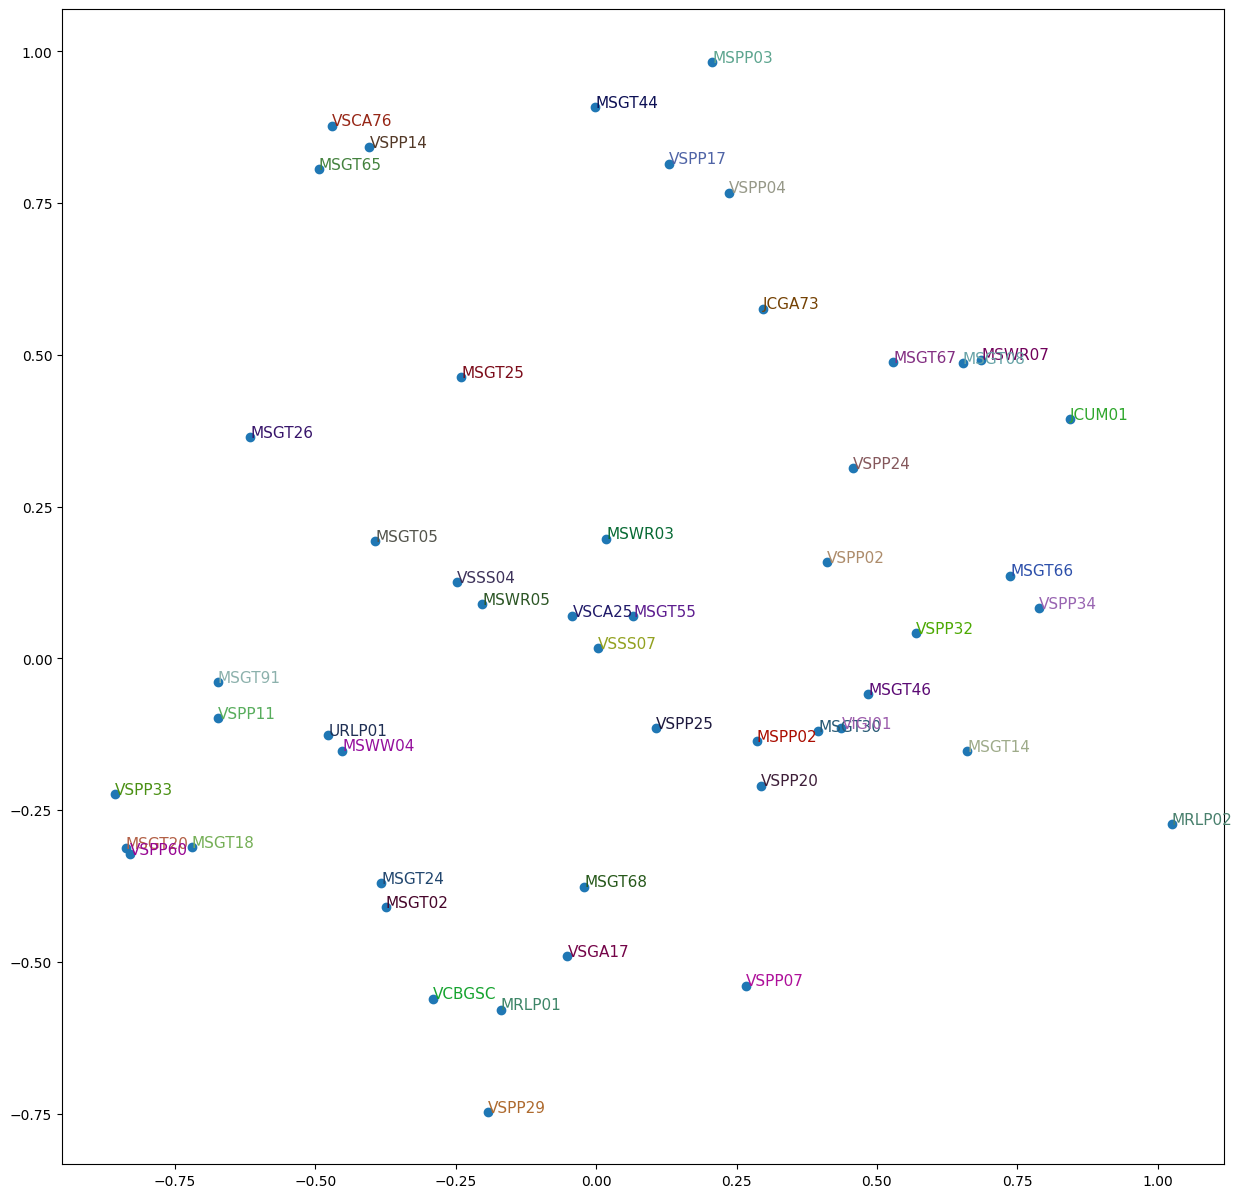

In [25]:
import matplotlib.pyplot as plt

idxs = np.random.choice(len(items), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(items[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

# Demonstrate selecting products to recommend for a single user

Next, let's get to our main goal of this model i.e. selecting new products to recommend for a user.

We can user the newly fitted model to select the top 5 recommended "new" items for the user 1

In [26]:
unknown_ratings_for_user_1 = test_df.iloc[:,:-1][test_df["user"] == 1]

In [28]:
row = learn.dls.test_dl(unknown_ratings_for_user_1)

pred = learn.get_preds(dl=row)
print(pred)
top_k_indices = pred[0].topk(5).indices.numpy()

print("Top 5 recommended products for user 1: ")
print(unknown_ratings_for_user_1["item"].iloc[top_k_indices])


(tensor([1.8799, 1.4807, 1.3240, 1.3465, 2.3356, 2.1454, 1.9426, 2.1601, 1.8578,
        1.9147, 0.7778, 1.9383, 2.2474, 1.8457, 2.0494, 2.1155, 1.0279, 1.4019,
        2.0004, 1.9780, 0.8209, 1.5774, 1.9318, 2.1238, 1.8024, 1.9116, 1.3538,
        2.0181, 1.5922, 2.5121, 1.0327, 1.5141]), None)
Top 5 recommended products for user 1: 
42    MSGT40
65    JCGA72
22    VSPP30
53     CIS04
56     AIS02
Name: item, dtype: object


# Test rating prediction RMSE on test data (i.e. for items that have not yet been used by the users)

Since we kept aside some of the items that users has rated in the test data, we can compare our model's predicted ratings for those items vs the true user ratings of the same items.

We will also compare using the RMSE metric.

In [239]:
row = learn.dls.test_dl(test_df.iloc[:,:-1])

pred = learn.get_preds(dl=row)[0].numpy()

# Calculate RMSE

In [240]:
np.sqrt(np.mean((test_df["rating"] - pred)**2))

np.float64(0.29524300123188824)

# How About Cold Starts?

A common question for collaborative filtering is how to deal with cold starts i.e. 
- for entirely new users that have not purchased nor rated any products.
- for new products that have not been rated by any users


## For entirely new users that have not purchased nor rated any products
One solution is to recommend more popular products based on the user's demographic/geographical information. Then once the user has purchased several products, we can begin to use the CF-based model.

## For new products that have not been rated by any users
One solution is to recommend the product if its metadata is similar to other products that the user has rated highly i.e. "content-based filtering".

